# Project: Forecast Daily Minimum Tempreature In Melbourne, Austrailia

In this notebook we will analyze daily dinimum temperatures in Melbourne so that we could predict what future values will be. 

In [1]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv("../data/daily-minimum-temperatures-in-me.csv")
df.head()

,Date,"Daily minimum temperatures in Melbourne, Australia, 1981-1990"
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [3]:
#set the name to temp and  date for ease access
df.columns = ['date','temp']
#make sure pandas not interpreting date as str 

df['date'] = pd.to_datetime(df['date'])

#set the date as the index for ease retrival
df.set_index('date',inplace=True)


In [4]:
# let's convert temp from str to float
df['temp'].astype(float)
#OOooh NO! it seems data not cleaned :(

ValueError: could not convert string to float: '?0.2'

In [5]:
# let's convert to float and in case of wrong value it will be nan:
modified_temp = pd.to_numeric(df['temp'], errors='coerce')

In [6]:
#let's see how many nan values we have!
modified_temp.isnull().value_counts()

temp
False    3647
True        3
Name: count, dtype: int64

In [7]:
# as we could see we have 3 wrong values. let's see what they are:
df['temp'][modified_temp.apply(pd.isna)]

#since it's time series problem, we can't simply drop these rows since it will affect consistency. There is several ways to fills values, such as: mean,median,min,max,intorpolate(linear,slinear, quadratic, cubic, barycentric,etc.)

# to replace NaNs with mean, I was wondering if should I calculate the mean for July only(since all the values missing are only in that month) or for the all the winter.
# When I searched for when winter in Melbourne is: "With its variable climate, Melbourne heats up December to February (summer), cools down March to May (autumn), chills out June to August (winter), and warms up again September to November (spring)."




date
1982-07-20    ?0.2
1982-07-21    ?0.8
1984-07-14    ?0.1
Name: temp, dtype: object

In [8]:
#based on that, I will replace it initially with weighted mean of july in 1982 for the first 19 days since they give nearest values and 1984.:

modified_temp.loc["1982-07-01":"1982-07-19"]

date
1982-07-01    4.2
1982-07-02    1.6
1982-07-03    2.6
1982-07-04    3.4
1982-07-05    3.9
1982-07-06    7.0
1982-07-07    7.8
1982-07-08    5.3
1982-07-09    2.4
1982-07-10    2.8
1982-07-11    4.0
1982-07-12    7.5
1982-07-13    7.8
1982-07-14    5.6
1982-07-15    3.3
1982-07-16    5.0
1982-07-17    3.7
1982-07-18    3.9
1982-07-19    5.2
Name: temp, dtype: float64

In [9]:
#based on that, I will replace it initially with weighted mean of july in 1982 for the first 19 days since they give nearest values and 1984.:
values =  modified_temp.loc["1982-07-01":"1982-07-19"]
weights = pd.Series([i for i in range(1, 20)], index=pd.date_range("1982-07-01", "1982-07-19"))
july_1982_weighted_mean = (values.mul(weights, axis=0)).sum() / weights.sum()

july_1982_weighted_mean

np.float64(4.800526315789473)

In [10]:
modified_temp['1982-07'] = modified_temp['1982-07'].fillna(july_1982_weighted_mean)


In [11]:
modified_temp.loc["1984-07-01":"1984-07-13"]

date
1984-07-01    7.8
1984-07-02    2.6
1984-07-03    2.4
1984-07-04    3.9
1984-07-05    1.3
1984-07-06    2.1
1984-07-07    7.4
1984-07-08    7.2
1984-07-09    8.8
1984-07-10    8.9
1984-07-11    8.8
1984-07-12    8.0
1984-07-13    0.7
Name: temp, dtype: float64

In [12]:
#let's do the same thing for july/1984
values =  modified_temp.loc["1984-07-01":"1984-07-13"]
weights = pd.Series([i for i in range(1, 14)], index=pd.date_range("1984-07-01", "1984-07-13"))
july_1984_weighted_mean = (values.mul(weights, axis=0)).sum() / weights.sum()

july_1984_weighted_mean

np.float64(5.872527472527472)

In [13]:
modified_temp['1984-07'] = modified_temp['1984-07'].fillna(july_1984_weighted_mean)


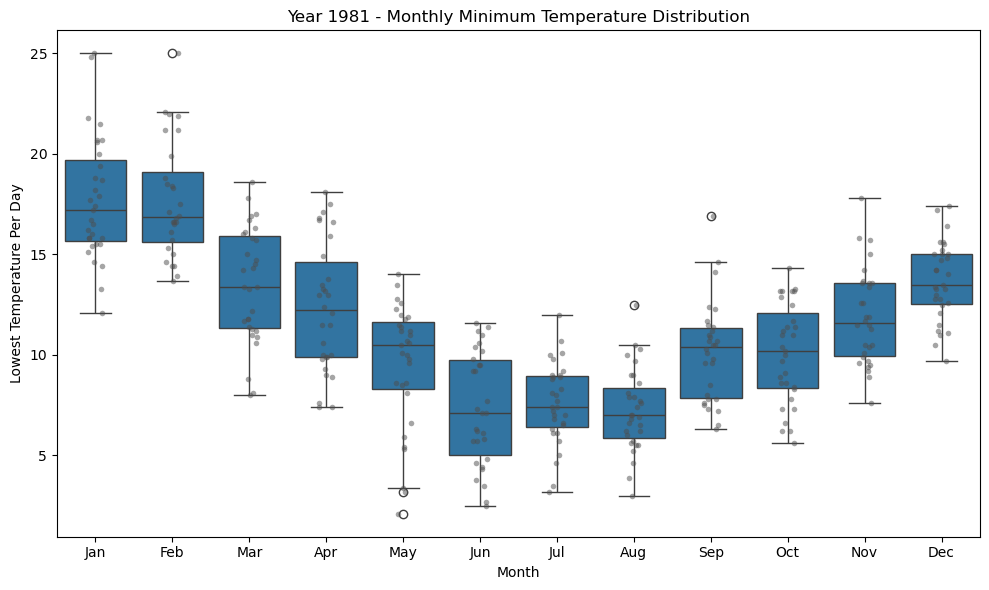

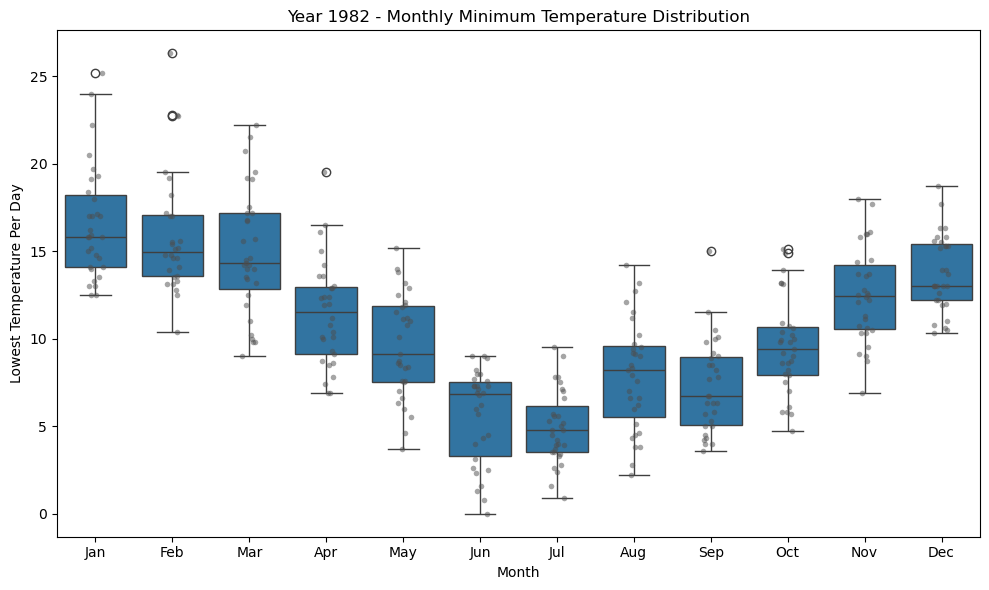

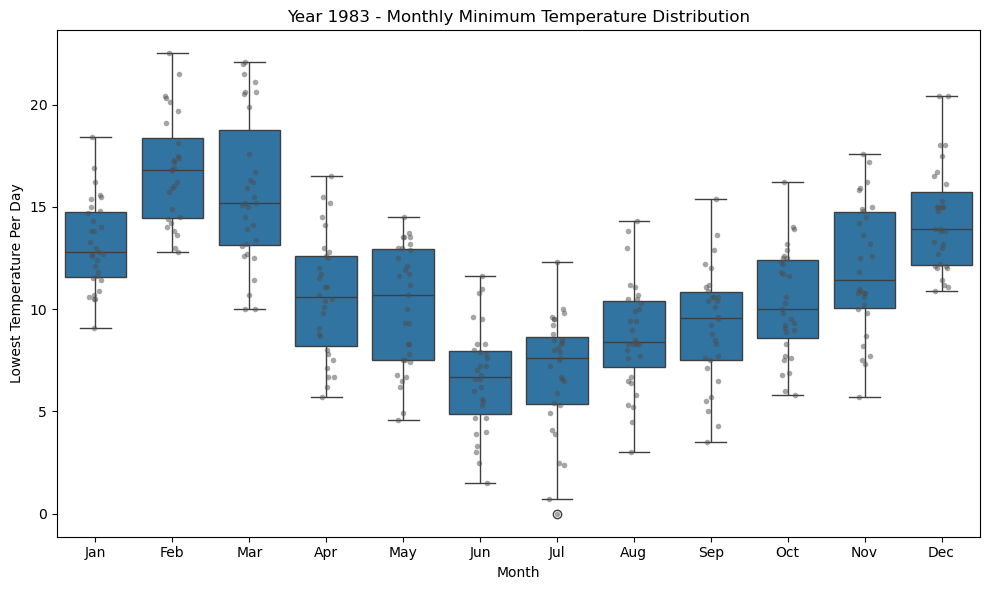

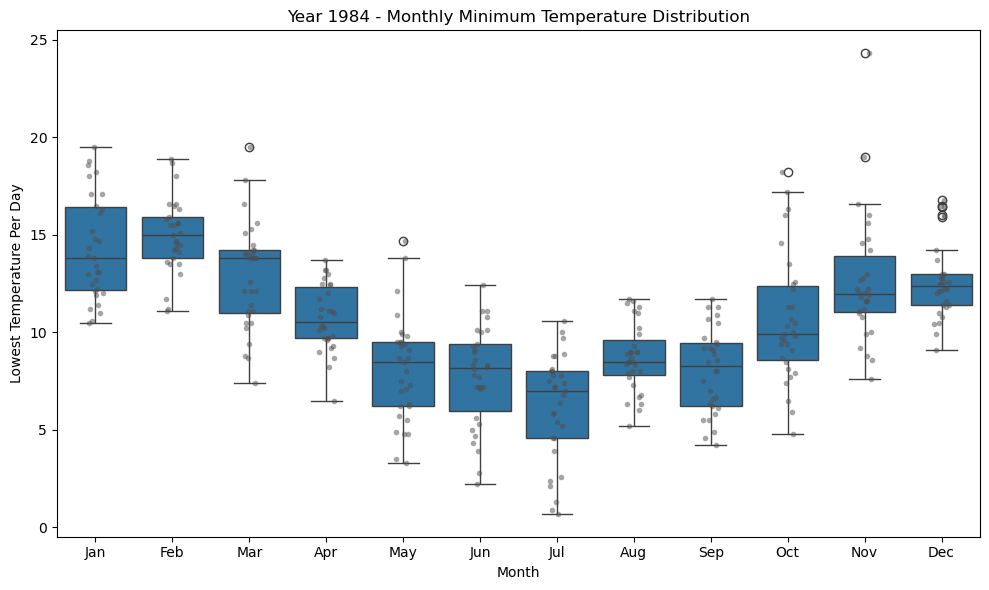

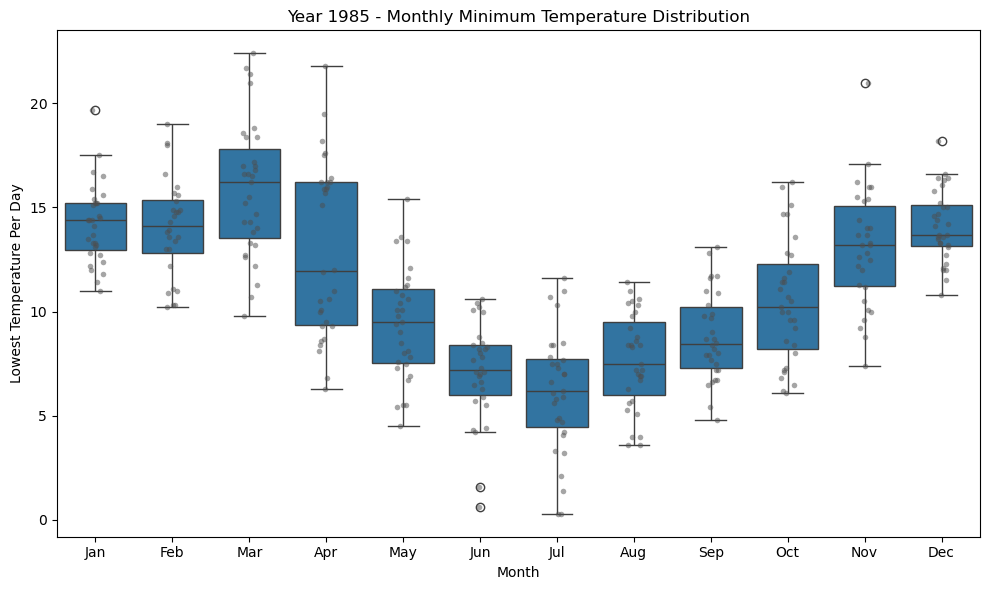

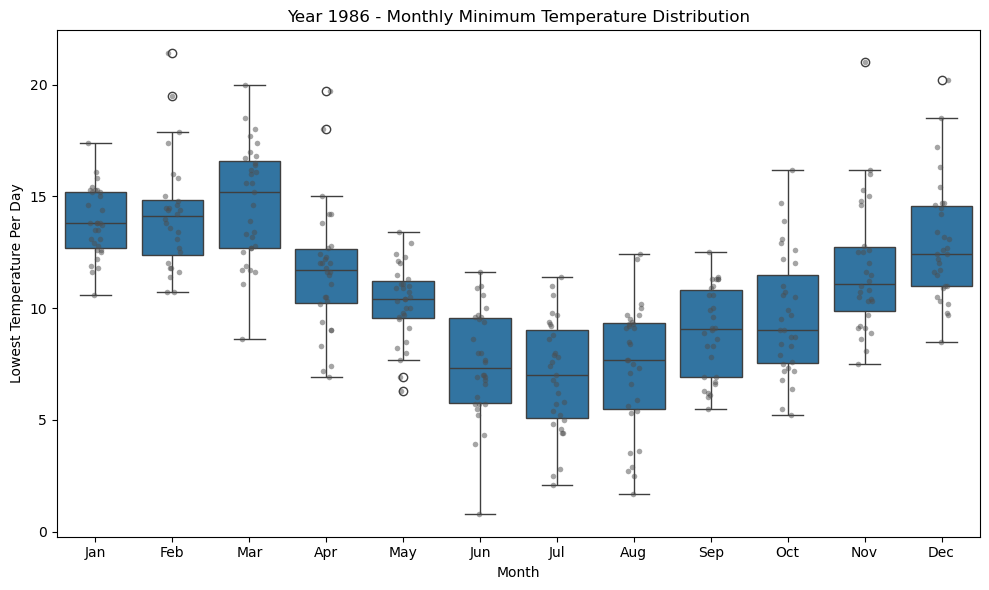

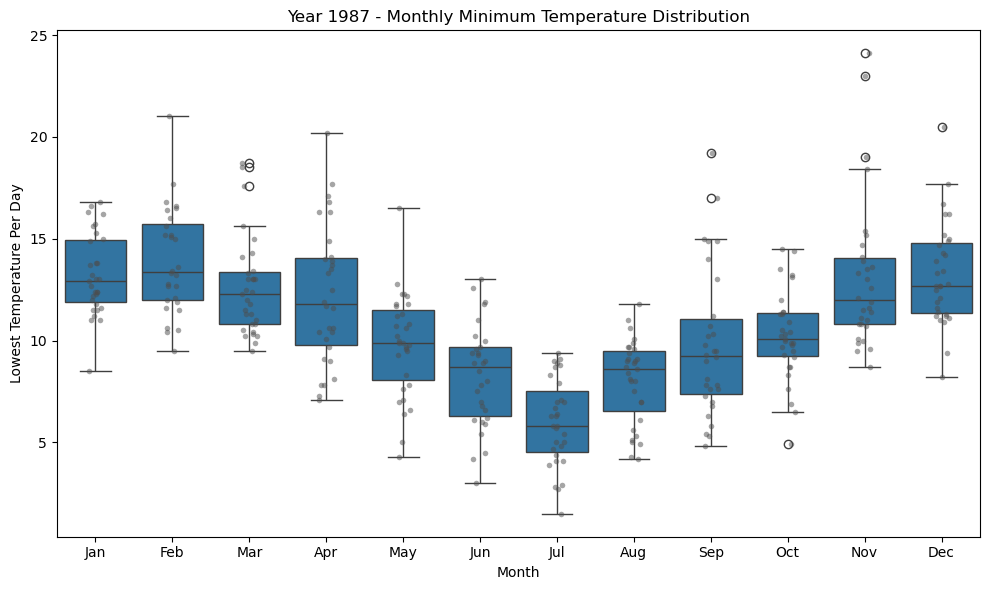

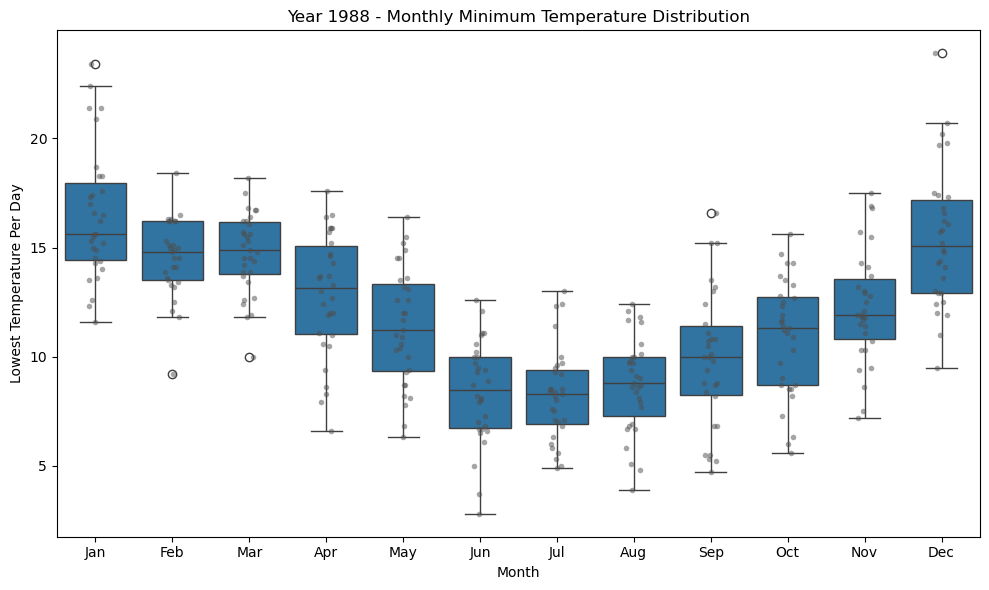

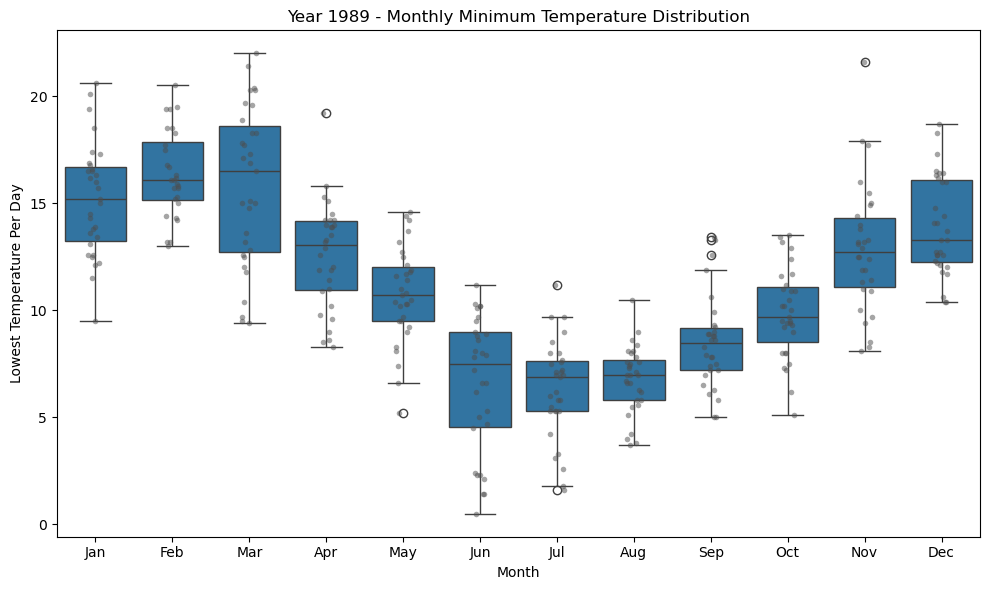

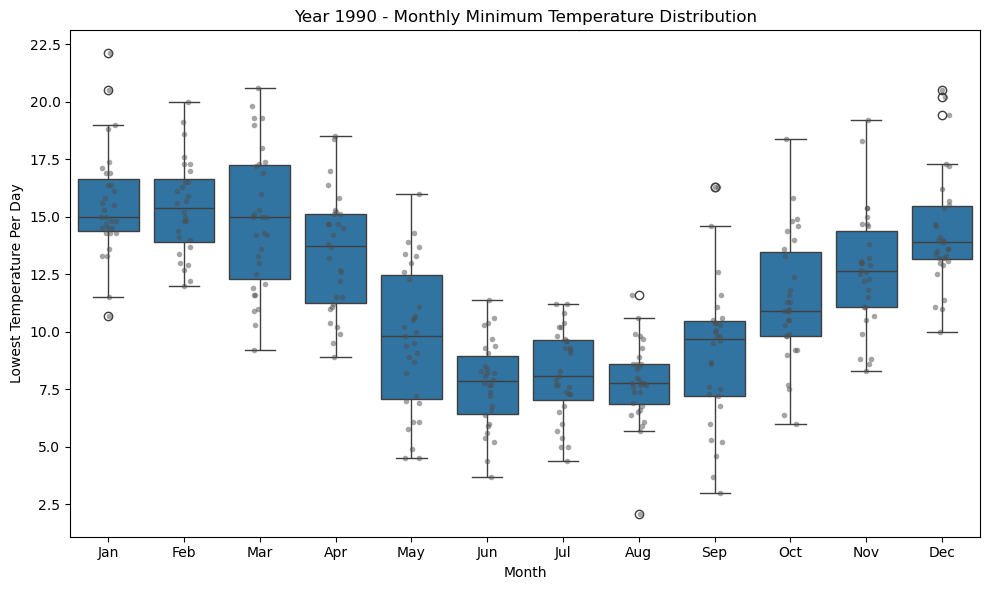

In [14]:
years = modified_temp.index.year.unique()

for year in years:
    year_data = modified_temp[modified_temp.index.year == year]
    
    plt.figure(figsize=(10, 6))
    
    sns.boxplot(x=year_data.index.month, y=year_data.values)
    sns.stripplot(x=year_data.index.month, y=year_data.values, size=4, color=".3", alpha=0.5)    


    plt.title(f"Year {year} - Monthly Minimum Temperature Distribution")
    plt.xlabel("Month")
    plt.ylabel("Lowest Temperature Per Day")
    plt.xticks(ticks=range(12), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])


    plt.tight_layout()
    
 
    plt.savefig(f"../plots/outliers/outliers_{year}.png")


In [15]:
# let's explore the datases:
# first, let's see the global statistics to get a general scense
modified_temp.groupby([modified_temp.index.year,modified_temp.index.month]).describe(include='all').to_csv("../analyses/summary_statistics_per_year_month.csv",index=False)

In [16]:
df['temp'] = modified_temp


In [17]:
df.to_csv("../data/cleaned_daily-minimum-temperatures-in-me.csv",index=True)

# findings

After we did statistical analysis, we:
- cleaned the data and replace nan values with resonable huiristic.
- find that there are several values that are outliers and probably a human mistake. eg. avg is 5 and minimum_value in the month is 0.9.

given outliers, the avg affected which affect our resonable huiristic too. for now we will go into time series analysis and modelling. with taking outliers in hands.